In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap

## Retrieve Data

In [2]:
df = pd.read_excel('C:/Users/YuxuanLiu/Desktop/5900/2023 Activity Standards.xlsx', engine='openpyxl')
dz = pd.read_excel('C:/Users/YuxuanLiu/Desktop/5900/2023 Load Data ALL DCS.xlsx', engine='openpyxl')

## Merging of data

### Harmonized load format

In [3]:
dz = dz.rename(columns={'Load #': 'Load'})
dz['Load'] = dz['Load'].astype(str)

#### Cases that need to be deleted from the activity file

In [4]:
load_counts = df['Load'].value_counts()
values_to_keep = load_counts[load_counts != 1].index
filtered_df = df[df['Load'].isin(values_to_keep)]
filtered_df=filtered_df.sort_values(by='Load')
duplicates = df[df.duplicated(subset=['Load', 'Start Time'], keep=False)]
duplicates_sorted = duplicates.sort_values(by='Load')
duplicates_sorted[['Load','Stop','Company ID','Address','Start Time','Dock Time','Piece Cnt']]

,Load,Stop,Company ID,Address,Start Time,Dock Time,Piece Cnt
9478,8936639,2,13195200,9030 GENERAL DR,2023-01-23 11:30:00.000,00:25:27.003000,815.0
9552,8936639,3,MKTROM,29275 Citrin Dr.,2023-01-23 11:30:00.000,00:25:27.003000,316.0
19865,8982997,2,12006600,17000 ROCKSIDE RD,2023-02-14 12:00:00.000,02:00:00,528.0
19918,8982997,3,12006602,17000 ROCKSIDE RD.,2023-02-14 12:00:00.000,01:37:00,139.0
63765,9162402,3,13609738,#14 ROTTERDAM INDUSTRIAL,2023-05-18 17:30:00.000,00:58:15.093000,910.0
63766,9162402,4,24039204,#14 ROTTERDAN INDUSTRIAL PARK,2023-05-18 17:30:00.000,00:58:15.093000,282.0
70038,9191293,2,23941300,5675 Sunol Blvd.,2023-06-01 06:38:09.013,02:03:06.004000,363.0
70045,9191293,3,13201501,5675 SUNOL BLVD,2023-06-01 06:38:09.013,02:03:06.004000,1345.0
71219,9196616,2,13606702,4770 NAVARRE ROAD SW,2023-06-05 08:49:23.013,00:29:54.010000,144.0
71253,9196616,3,13606701,4719 NAVARRE RD SW,2023-06-05 08:49:23.013,00:29:54.010000,67.0


#### Cases that need to be deleted from the #load file

In [5]:
load_counts2 = dz['Load'].value_counts()
values_to_keep2 = load_counts2[load_counts2 != 1].index
filtered_df2 = dz[dz['Load'].isin(values_to_keep2)]
# where the ids are the same and the others are different
data2 = filtered_df2[~filtered_df2.duplicated(subset=['Load', 'Trailer Type'], keep=False)]
data2=data2.sort_values(by='Load')
data2.head(20)

,Load,Trailer Type,Frt Tmp,Mid Tmp,Rear Tmp,Dry Piece Count,Refrig Piece Count,Frozen Piece Count
74878,0,PALLETS,,,,147070.0,30880.0,459375.0
27261,8870537,MIXED,0/4,45/49,x/46,2184.0,0.0,181.0
27318,8870537,EMPTY,x,x,x,2180.0,0.0,183.0
234135,8874561,MIXED,65/64,x/65,x/61,2571.0,0.0,0.0
234202,8874561,DRY,x,x,x,2551.0,0.0,0.0
16219,8877320,MIXED,0/3,x,x,0.0,0.0,0.0
80432,8877320,EMPTY,X,X,X,0.0,0.0,0.0
184021,8881805,FROZEN,0/0,x,x,0.0,0.0,877.0
184022,8881805,EMPTY,,,,0.0,0.0,877.0
184025,8882512,DRY,x,x,x,0.0,0.0,1752.0


### Delete the two cases mentioned above

In [6]:
df=df[~df['Load'].isin(duplicates_sorted['Load'].unique())]
dz=dz[~dz['Load'].isin(data2['Load'].unique())]

### Combining data

In [7]:
merged_df_inner = pd.merge(df, dz, on='Load', how='inner')
merged_df_inner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151114 entries, 0 to 151113
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Load                       151114 non-null  object        
 1   Stop                       151114 non-null  int64         
 2   Driver Region              151114 non-null  object        
 3   Driver ID                  151114 non-null  object        
 4   Driver                     151114 non-null  object        
 5   Company ID                 151114 non-null  object        
 6   Company                    151114 non-null  object        
 7   Address                    151114 non-null  object        
 8   City                       151114 non-null  object        
 9   State                      151114 non-null  object        
 10  Routing Region             151114 non-null  object        
 11  Miles From Prev Stop       151114 non-null  int64   

## data cleaning

### special variable

In [8]:
#Delete with STC
merged_df_inner = merged_df_inner[merged_df_inner['STC'].isna()]

### outlier

In [9]:
#load
merged_df_inner[~merged_df_inner['Load'].apply(pd.to_numeric, errors='coerce').notna()]['Load'].unique()
#driver region
print(merged_df_inner['Driver Region'].unique()) #NONDRV
merged_df_inner['Driver Region'] = merged_df_inner['Driver Region'].replace('NONDRV', np.nan)
#driver id
print(merged_df_inner[~merged_df_inner['Driver ID'].apply(pd.to_numeric, errors='coerce').notna()]['Driver ID'].unique() )#UNKNOWN
merged_df_inner['Driver ID'] = merged_df_inner['Driver ID'].replace('UNKNOWN', np.nan)
#company id 
print(merged_df_inner[~merged_df_inner['Company ID'].apply(pd.to_numeric, errors='coerce').notna()]['Company ID'].unique())
merged_df_inner['Company ID'] = pd.to_numeric(merged_df_inner['Company ID'], errors='coerce')
#trailer type
print(merged_df_inner['Trailer Type'].unique())
merged_df_inner['Trailer Type'] = merged_df_inner['Trailer Type'].apply(
    lambda x: x.upper() if isinstance(x, str) and x.isalpha() else np.nan
)
#frt tmp, mid tmp, rear tmp
pattern = r'^\d+/\d+$|^[xX]$'

merged_df_inner['Frt Tmp'] = merged_df_inner['Frt Tmp'].where(merged_df_inner['Frt Tmp'].str.match(pattern))
merged_df_inner['Mid Tmp'] = merged_df_inner['Mid Tmp'].where(merged_df_inner['Mid Tmp'].str.match(pattern))
merged_df_inner['Rear Tmp'] = merged_df_inner['Rear Tmp'].where(merged_df_inner['Rear Tmp'].str.match(pattern))

def split_temp_column(col):
    set_temp = []
    actual_temp = []

    for value in col:
        if isinstance(value, str) and '/' in value:
            temps = value.split('/')
            set_temp.append(int(temps[0]))
            actual_temp.append(int(temps[1]))
        elif isinstance(value, str) and value.lower() == 'x':
            set_temp.append(np.nan)
            actual_temp.append(np.nan)
        else:
            set_temp.append(np.nan)
            actual_temp.append(np.nan)

    return set_temp, actual_temp


merged_df_inner['Frt Set Temp'], merged_df_inner['Frt Actual Temp'] = split_temp_column(merged_df_inner['Frt Tmp'])
merged_df_inner['Mid Set Temp'], merged_df_inner['Mid Actual Temp'] = split_temp_column(merged_df_inner['Mid Tmp'])
merged_df_inner['Rear Set Temp'], merged_df_inner['Rear Actual Temp'] = split_temp_column(merged_df_inner['Rear Tmp'])


merged_df_inner.drop(columns=['Frt Tmp', 'Mid Tmp', 'Rear Tmp'], inplace=True)


print(merged_df_inner[['Frt Set Temp', 'Frt Actual Temp', 'Mid Set Temp', 'Mid Actual Temp', 'Rear Set Temp', 'Rear Actual Temp']].head())

['CH' 'MD' 'IN' 'NY' 'CA' 'GA' 'AZ' 'ID' 'OK' 'IL4' 'IL5' 'TN' 'IL2' 'DE'
 'IL3' 'IL7' 'MH' 'IL1' 'IL8' 'IL6' 'UNK' 'MC' 'NONDRV']
['UNKNOWN']
['SAGFOR' 'DC01' 'DC16' 'BAKBAK03' 'NORNOR10' 'DC13' 'CHALOT' 'LEBTER'
 'DC19' 'DC41' 'OKLOKL' 'KINGEI' 'STRSTR' 'COSLYO' 'OCATER']
['MIXED' nan 'Mixed' 'Ref' 'FROZEN' 'Dry' 'Frozen' 'DRY' 'REF' 'EMPTY']
   Frt Set Temp  Frt Actual Temp  Mid Set Temp  Mid Actual Temp  \
0          34.0             38.0          34.0             36.0   
1          34.0             38.0          34.0             36.0   
2           0.0              0.0          45.0             47.0   
3           0.0              0.0          45.0             47.0   
5           NaN              NaN           NaN              NaN   

   Rear Set Temp  Rear Actual Temp  
0            0.0              14.0  
1            0.0              14.0  
2           31.0              34.0  
3           31.0              34.0  
5            NaN               NaN  


### empty value

In [10]:
#Treating variables with fewer missing values and tentatively considered more important
merged_df_inner['Weight'].fillna(merged_df_inner['Weight'].median(), inplace=True)
merged_df_inner['Cube'].fillna(merged_df_inner['Cube'].median(), inplace=True)
merged_df_inner['Piece Cnt'].fillna(merged_df_inner['Piece Cnt'].median(), inplace=True)
merged_df_inner['Lines'].fillna(merged_df_inner['Lines'].median(), inplace=True)
merged_df_inner['Trailer Space Utilization'].fillna(merged_df_inner['Trailer Space Utilization'].median(), inplace=True)

# Delete null values based on correct column names
merged_df_inner.dropna(subset=['Driver Region', 'Company ID', 'Driver ID','Trailer Type','Dry Piece Count','Refrig Piece Count','Frozen Piece Count'], inplace=True)

# First, sort by Load and Piece Cnt in descending order
merged_df_inner = merged_df_inner.sort_values(by=['Load', 'Piece Cnt'], ascending=[True, False])

# Group by each Load
for load, group in merged_df_inner.groupby('Load'):
    # Get the maximum Piece Cnt and its corresponding Dry, Refrig, Frozen Piece Counts for the current Load
    max_piece_cnt = group.iloc[0]['Piece Cnt']
    max_dry_piece_count = group.iloc[0]['Dry Piece Count']
    max_refrig_piece_count = group.iloc[0]['Refrig Piece Count']
    max_frozen_piece_count = group.iloc[0]['Frozen Piece Count']
    
    # Check if there are any NaN values
    if pd.isna(max_piece_cnt) or pd.isna(max_dry_piece_count) or pd.isna(max_refrig_piece_count) or pd.isna(max_frozen_piece_count):
        continue  # Skip the group if maximum values contain NaN

    # Iterate through all rows in the current Load group, adjusting based on the maximum values
    for index, row in group.iterrows():
        # Calculate the adjusted Piece Counts based on proportions, ensuring NaN values are handled
        if not pd.isna(row['Piece Cnt']) and row['Piece Cnt'] > 0:
            adjusted_dry = (row['Piece Cnt'] / max_piece_cnt) * max_dry_piece_count
            adjusted_refrig = (row['Piece Cnt'] / max_piece_cnt) * max_refrig_piece_count
            adjusted_frozen = (row['Piece Cnt'] / max_piece_cnt) * max_frozen_piece_count

            # Update the adjusted values in the DataFrame, rounding to the nearest integer
            merged_df_inner.at[index, 'Adjusted Dry Piece Count'] = round(adjusted_dry)
            merged_df_inner.at[index, 'Adjusted Refrig Piece Count'] = round(adjusted_refrig)
            merged_df_inner.at[index, 'Adjusted Frozen Piece Count'] = round(adjusted_frozen)
        else:
            # Skip rows where Piece Cnt is NaN or 0
            merged_df_inner.at[index, 'Adjusted Dry Piece Count'] = np.nan
            merged_df_inner.at[index, 'Adjusted Refrig Piece Count'] = np.nan
            merged_df_inner.at[index, 'Adjusted Frozen Piece Count'] = np.nan

# View the results for Load 239168692
filtered_df = merged_df_inner[merged_df_inner['Load'] == '239168692']
print(filtered_df[['Load', 'Piece Cnt', 'Dry Piece Count', 'Refrig Piece Count', 'Frozen Piece Count', 
                  'Adjusted Dry Piece Count', 'Adjusted Refrig Piece Count', 'Adjusted Frozen Piece Count']])

            Load  Piece Cnt  Dry Piece Count  Refrig Piece Count  \
59456  239168692     1180.0            576.0               215.0   
59458  239168692      468.0            576.0               215.0   
59457  239168692       70.0            576.0               215.0   

       Frozen Piece Count  Adjusted Dry Piece Count  \
59456               459.0                     576.0   
59458               459.0                     228.0   
59457               459.0                      34.0   

       Adjusted Refrig Piece Count  Adjusted Frozen Piece Count  
59456                        215.0                        459.0  
59458                         85.0                        182.0  
59457                         13.0                         27.0  


### anova test

In [11]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Select relevant columns
df = merged_df_inner[['Driver Region', 'Driver', 'Company', 'Address', 'City', 'Routing Region', 'Dock Time Converted']]

# Convert categorical variables to string type
categorical_columns = ['Driver Region', 'Driver', 'Company', 'Address', 'City', 'Routing Region']
df[categorical_columns] = df[categorical_columns].astype(str)

# Define a function to perform ANOVA on a single variable
def perform_anova(column_name):
    formula = f'Q("Dock Time Converted") ~ Q("{column_name}")'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {column_name}:")
    print(anova_table[['F', 'PR(>F)']])
    print("\n")

# Perform ANOVA for each variable
for col in categorical_columns:
    perform_anova(col)

C:\Users\YuxuanLiu\AppData\Local\Temp\ipykernel_37452\454027001.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns] = df[categorical_columns].astype(str)


ANOVA results for Driver Region:
                            F         PR(>F)
Q("Driver Region")  45.304369  2.934174e-178
Residual                  NaN            NaN


ANOVA results for Driver:
                    F  PR(>F)
Q("Driver")  4.905554     0.0
Residual          NaN     NaN


ANOVA results for Company:
                      F  PR(>F)
Q("Company")  16.145481     0.0
Residual            NaN     NaN


ANOVA results for Address:
                     F  PR(>F)
Q("Address")  16.85368     0.0
Residual           NaN     NaN


ANOVA results for City:
                   F  PR(>F)
Q("City")  21.518489     0.0
Residual         NaN     NaN


ANOVA results for Routing Region:
                             F         PR(>F)
Q("Routing Region")  47.001502  1.501668e-203
Residual                   NaN            NaN




In [12]:
merged_df_inner.info

<bound method DataFrame.info of              Load  Stop Driver Region Driver ID           Driver  Company ID  \
59456   239168692     1            NY     27983      MARKMAZZOLA   1131200.0   
59458   239168692     3            NY     27983      MARKMAZZOLA  24137804.0   
59457   239168692     2            NY     27983      MARKMAZZOLA  21994200.0   
611       8854391     1           IL4     06188    CHARLESTHOMAS  23527606.0   
153       8855738     1            GA     42251   MARCUSROBINSON    145802.0   
...           ...   ...           ...       ...              ...         ...   
151109    9655392     1            OK     43691      ENRIQUEPOOL  24016416.0   
151110    9661518     1            MD     24728  MICHAELCHALUPKA  21397707.0   
151111    9661589     1            CA     40803    DIEGOCALDERON  13609716.0   
151112    9665842     1            CH     45070       JAYLAWHITE  23911504.0   
151113    9668638     1            CH     35459     BRYSONPATTON  23911503.0   

       

In [13]:
# Define the states in each region
northeastern_states = ['NY', 'NJ', 'CT', 'MA', 'PA', 'VT', 'NH', 'ME', 'RI']
western_states = ['CA', 'OR', 'WA', 'NV', 'AZ', 'CO', 'UT', 'ID', 'MT', 'WY']
southern_states = ['TX', 'FL', 'GA', 'SC', 'NC', 'AL', 'MS', 'LA', 'AR', 'OK']
midwestern_states = ['IL', 'IN', 'OH', 'MI', 'WI', 'IA', 'MO', 'MN', 'KS', 'NE']

# Create a function to map each state to a region
def get_region(state):
    if state in northeastern_states:
        return 'Northeast'
    elif state in western_states:
        return 'West'
    elif state in southern_states:
        return 'South'
    elif state in midwestern_states:
        return 'Midwest'
    else:
        return 'Other'

# Apply the function to create a new 'Region' column in your DataFrame
merged_df_inner['Region'] = merged_df_inner['State'].apply(get_region)

# Calculate total dock time and total piece count per state
state_docktime_piece_count = merged_df_inner.groupby('State').agg({
    'Dock Time Converted': 'sum',
    'Piece Cnt': 'sum'
}).reset_index()

# Calculate dock time per piece count for each state
state_docktime_piece_count['Dock Time Per Piece'] = state_docktime_piece_count['Dock Time Converted'] / state_docktime_piece_count['Piece Cnt']

# Map each state to its region for the aggregated data
state_docktime_piece_count['Region'] = state_docktime_piece_count['State'].apply(get_region)

# Calculate mean dock time per piece count by region and sort in descending order
region_docktime_per_piece = state_docktime_piece_count.groupby('Region')['Dock Time Per Piece'].mean().reset_index()
region_docktime_per_piece = region_docktime_per_piece.sort_values(by='Dock Time Per Piece', ascending=False)

In [14]:
nan_mask = merged_df_inner['Address'].isna()
print(nan_mask)

59456     False
59458     False
59457     False
611       False
153       False
          ...  
151109    False
151110    False
151111    False
151112    False
151113    False
Name: Address, Length: 98108, dtype: bool


In [15]:
merged_df_inner.to_csv('merged_df_inner.csv', index=False) 

### cluster

In [16]:
from sklearn.cluster import KMeans
import pandas as pd

# Assume merged_df_inner is your dataset

# Calculate the mean of 'Dock Time Converted' for each category
driver_means = merged_df_inner.groupby('Driver')['Dock Time Converted'].mean()
company_means = merged_df_inner.groupby('Company')['Dock Time Converted'].mean()
address_means = merged_df_inner.groupby('Address')['Dock Time Converted'].mean()
city_means = merged_df_inner.groupby('City')['Dock Time Converted'].mean()
routing_region_means = merged_df_inner.groupby('Routing Region')['Dock Time Converted'].mean()
driver_region_means = merged_df_inner.groupby('Driver Region')['Dock Time Converted'].mean()
region_means = merged_df_inner.groupby('Region')['Dock Time Converted'].mean()

# Set the number of clusters for K-means, e.g., 3 clusters (high, medium, low)
n_clusters = 3

# Perform clustering on the means of each variable
driver_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(driver_means.values.reshape(-1, 1))
company_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(company_means.values.reshape(-1, 1))
address_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(address_means.values.reshape(-1, 1))
city_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(city_means.values.reshape(-1, 1))
routing_region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(routing_region_means.values.reshape(-1, 1))
driver_region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(driver_region_means.values.reshape(-1, 1))
region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(region_means.values.reshape(-1, 1))

# Map the clustering results back to the original data
merged_df_inner['Driver_Cluster'] = merged_df_inner['Driver'].map(dict(zip(driver_means.index, driver_clusters)))
merged_df_inner['Company_Cluster'] = merged_df_inner['Company'].map(dict(zip(company_means.index, company_clusters)))
merged_df_inner['Address_Cluster'] = merged_df_inner['Address'].map(dict(zip(address_means.index, address_clusters)))
merged_df_inner['City_Cluster'] = merged_df_inner['City'].map(dict(zip(city_means.index, city_clusters)))
merged_df_inner['Routing_Region_Cluster'] = merged_df_inner['Routing Region'].map(dict(zip(routing_region_means.index, routing_region_clusters)))
merged_df_inner['Driver_Region_Cluster'] = merged_df_inner['Driver Region'].map(dict(zip(driver_region_means.index, driver_region_clusters)))
merged_df_inner['Region_Cluster'] = merged_df_inner['Region'].map(dict(zip(region_means.index, region_clusters)))

# View the results
print(merged_df_inner[['Driver', 'Driver_Cluster', 'Company', 'Company_Cluster', 'Address', 'Address_Cluster', 'City', 'City_Cluster']].head())

C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

               Driver  Driver_Cluster                   Company  \
59456     MARKMAZZOLA               0           HPC FOODSERVICE   
59458     MARKMAZZOLA               0      STOP&SHOP/MANCHESTER   
59457     MARKMAZZOLA               0  RESTAURANT EQUIPMENT PAR   
611     CHARLESTHOMAS               0      WALGREENS/MT. VERNON   
153    MARCUSROBINSON               2           USF/PORT ORANGE   

       Company_Cluster                              Address  Address_Cluster  \
59456                1  625 NUTMEG RD N                                    0   
59458                0  1315 TOLLAND TURNPIKE                              0   
59457                1  465 PARK AVENUE                                    1   
611                  1  5100 LAKE TERRACE NE                               1   
153                  0  5425 S WILLIAMSON BLVD                             0   

                City  City_Cluster  
59456  South Windsor             1  
59458     Manchester             0  
59457

In [17]:
print(merged_df_inner['Driver_Region_Cluster'])

59456     1
59458     1
59457     1
611       1
153       2
         ..
151109    2
151110    2
151111    1
151112    1
151113    1
Name: Driver_Region_Cluster, Length: 98108, dtype: int32


### one-hot encoding

In [18]:
merged_df_inner_2 = pd.get_dummies(merged_df_inner, columns=['Driver_Cluster','City_Cluster','Company_Cluster','Address_Cluster','Trailer Type','Appt Day','State'], dummy_na=True, drop_first=True)

### model creation preparation

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

columns_to_drop = ['Load', 'Planned Time', 'Print Of DR', 'Load Due Out', 'Driver ID','Company ID',
                   'DC Departure', 'GPS Arrival', 'GPS Departure', 'Per', 'STC','Cube','Trailer Space Utilization',
                   'FCFS', 'Start Time', 'Dock Time','Dry Piece Count', 'Refrig Piece Count', 'Frozen Piece Count','Miles From Prev Stop',
                   'Appt Week', 'DepartBeforeAppt', 'GPSERROR', 'LATE', 'Skipped','Appt','Frt Set Temp', 'Frt Actual Temp', 'Mid Set Temp', 'Mid Actual Temp', 'Rear Set Temp', 'Rear Actual Temp',]
# Remove unselected columns from DataFrame
merged_df_inner_3 = merged_df_inner_2.drop(columns=columns_to_drop)
merged_df_inner_3 = merged_df_inner_3.dropna()
merged_df_inner_3.to_csv('merged_df_inner_3(Final_dataset).csv', index=False)

### model creation

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Step 1: Separate features (X) and target (y)
X = merged_df_inner_3.drop(columns=['Dock Time Converted','Routing Region','Driver Region','Driver','Company', 'Address', 'City','Region'])  # Features
y = merged_df_inner_3['Dock Time Converted']  # Target

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]  # Number of samples in the test set
    p = X_test.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"{model.__class__.__name__} - RMSE: {rmse:.2f}, R²: {r2:.2f}, Adjusted R²: {adjusted_r2:.2f}")
    return rmse, r2, adjusted_r2

# Step 3: Initialize models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linear_model.fit(X_train_scaled, y_train)
evaluate_model(linear_model, X_test_scaled, y_test)

random_forest_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=84
)
random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, X_test, y_test)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test)

LinearRegression - RMSE: 2.64, R²: 0.31, Adjusted R²: 0.31
RandomForestRegressor - RMSE: 2.27, R²: 0.49, Adjusted R²: 0.49
XGBRegressor - RMSE: 2.25, R²: 0.50, Adjusted R²: 0.50


(2.248642015878879, 0.5006806182572325, 0.4985297039974175)

### model feature importance

   Top 10 Features by Random Forest Importance:
                        Feature  RF_Importance
17          Company_Cluster_1.0       0.318050
4                     Time Diff       0.193437
2                     Piece Cnt       0.106830
3                         Lines       0.059905
1                        Weight       0.058186
5      Adjusted Dry Piece Count       0.050185
7   Adjusted Frozen Piece Count       0.038610
6   Adjusted Refrig Piece Count       0.034495
12           Driver_Cluster_2.0       0.013595
20          Address_Cluster_1.0       0.012883
   Top 10 Features by Linear Regression Coefficients:
                Feature  Linear_Coefficient
22  Address_Cluster_nan        2.148060e+12
27     Trailer Type_nan        6.616653e+11
10       Region_Cluster        5.186051e+11
70             State_PA        3.029433e+11
66             State_NY        2.936786e+11
63             State_NJ        2.594537e+11
77             State_VA        2.121230e+11
37             State_CA      

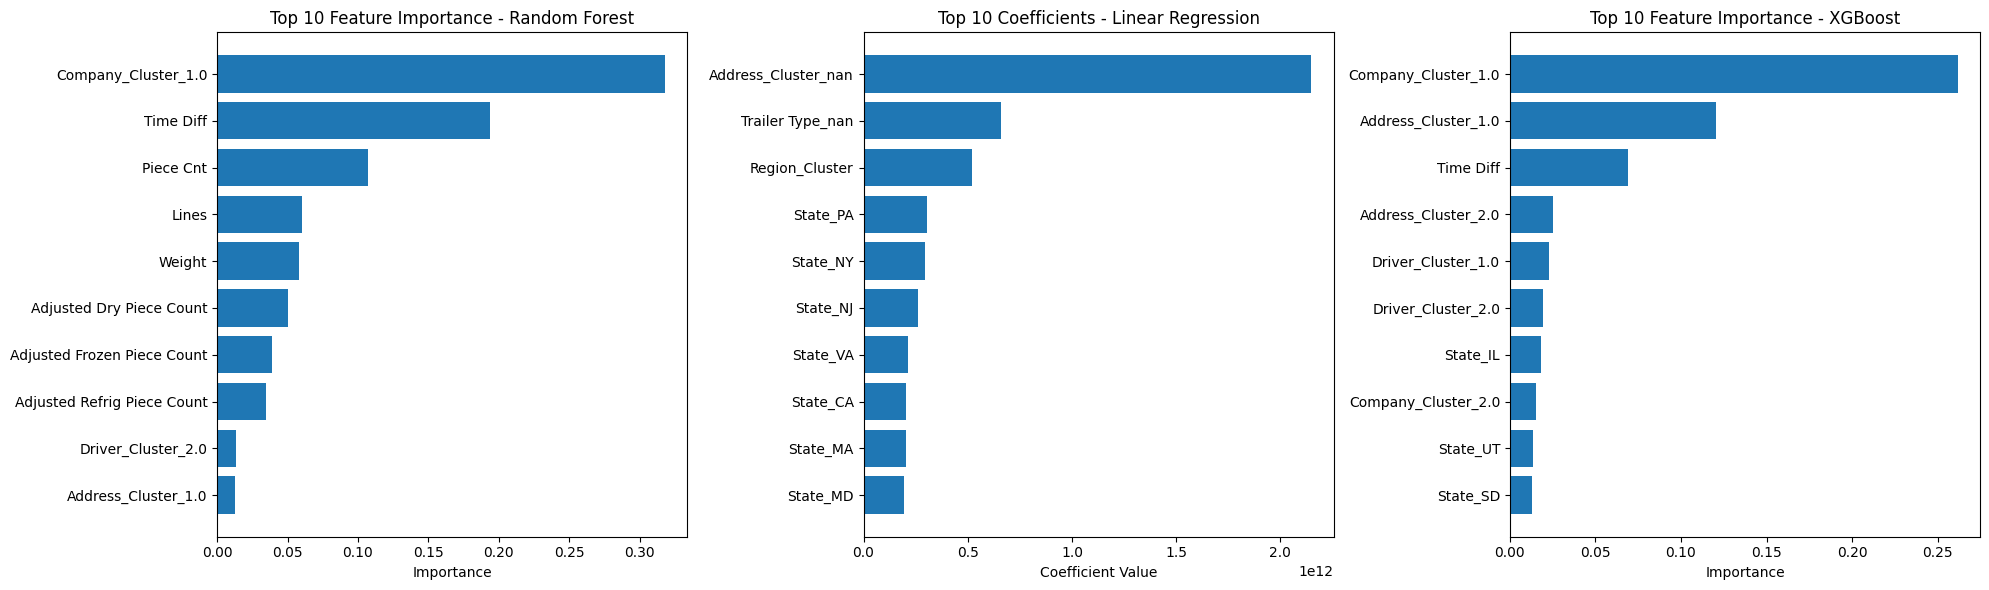

In [21]:
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': random_forest_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False).head(10)

# Linear Regression Coefficients
linear_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Coefficient': linear_model.coef_
}).sort_values(by='Linear_Coefficient', ascending=False).head(10)

# XGB Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values(by='XGB_Importance', ascending=False).head(10)

# Display the top 10 features for each model
print("   Top 10 Features by Random Forest Importance:")
print(rf_importance)
print("   Top 10 Features by Linear Regression Coefficients:")
print(linear_coefficients)
print("   Top 10 Features by XGB Importance:")
print(xgb_importance)

# Plotting each model's top 10 influential features in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Random Forest Plot
axes[0].barh(rf_importance['Feature'], rf_importance['RF_Importance'])
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 10 Feature Importance - Random Forest")
axes[0].invert_yaxis()

# Linear Regression Plot
axes[1].barh(linear_coefficients['Feature'], linear_coefficients['Linear_Coefficient'])
axes[1].set_xlabel("Coefficient Value")
axes[1].set_title("Top 10 Coefficients - Linear Regression")
axes[1].invert_yaxis()

# XGB Plot
axes[2].barh(xgb_importance['Feature'], xgb_importance['XGB_Importance'])
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Feature Importance - XGBoost")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()